# The Scaling of the Gate-Block Library

In [11]:
using JLD2, CairoMakie

## Default Restrictions

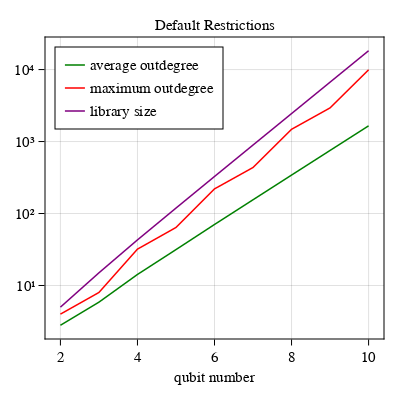

In [12]:
# The analytical expression for the total number of quantum gate-blocks
f(k) = Int( round( ((1+3^0.5)^(k+1) - (1-3^0.5)^(k+1))/(2*3^0.5) ) ) -1

# The numerical results for the number of outdegrees
num_ave_history_default = load_object("num_ave_history_default.jld2")
num_max_history_default = load_object("num_max_history_default.jld2")

# fig = Figure(resolution = (3000, 3000))
size_inches = (4, 4)
size_pt = 100 .* size_inches
fig = Figure(resolution = size_pt, font = "Times", fontsize = 15)

lines(fig[1, 1], 2:10, num_ave_history_default, color = :green, axis = (yscale = log10, title = "Default Restrictions", xlabel = "qubit number"), label = "average outdegree")
lines!(fig[1, 1], 2:10, num_max_history_default, color = :red, label = "maximum outdegree"  )
lines!(fig[1, 1], 2:10, f.(2:10), color = :purple, label = "library size" )
axislegend(position = :lt)
# save("exp.pdf", fig, pt_per_unit = 1)
fig

## Further Restrictions 

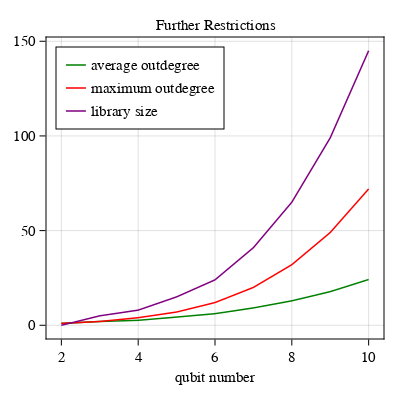

In [11]:
# The analytical expression for the total number of quantum gate-blocks
f(k) = Int( sum(2^(!(k-2i == 0)) * binomial(k-i,i) for i in 0:cut_off) - 1 )
# Set the cutoff constant 
cut_off = 3
# The numerical results for the number of outdegrees
num_ave_history_restricted = load_object("num_ave_history_restricted.jld2")
num_max_history_restricted = load_object("num_max_history_restricted.jld2")

# fig = Figure(resolution = (3000, 3000))
size_inches = (4, 4)
size_pt = 100 .* size_inches
fig = Figure(resolution = size_pt, font = "Times", fontsize = 15)

lines(fig[1, 1], 2:10, num_ave_history_restricted[cut_off], color = :green, axis = (title = "Further Restrictions", xlabel = "qubit number"), label = "average outdegree")
lines!(fig[1, 1], 2:10, num_max_history_restricted[cut_off], color = :red, label = "maximum outdegree"  )
lines!(fig[1, 1], 2:10, f.(2:10), color = :purple, label = "library size" )
axislegend(position = :lt)
# save("poly.pdf", fig, pt_per_unit = 1)
fig

# Source Code for Building up the Gate-Block Library

In [1]:
using JLD2, Combinatorics

## Default Restrictions

In [ ]:
# construct the gate-block library  
function gate_block_library(nqubits)   
    k = nqubits ;
    library  = [] ;
    temp = permutations(collect(1:k)) |> collect;

    for iter in 0:Int(floor(k/2))

        ver = Int(floor(k/2)) - iter ; # the number of control-rx gate

        Column_set = [] ;
        temp1 = [] ;
        if ver == 0
            push!(temp1, zeros(Int,9)) ;
            Column_set = zeros(Int,Int(floor(k/2))*2+k, 1) ;
        elseif ver == 1
            for i in 1:length(temp)
                if sum(abs(temp[i][2j-1]-temp[i][2j]) == 1 for j in 1:ver ) == ver &&
                    !(temp[i][1:2*ver] in temp1)

                    push!(temp1, temp[i][1:2*ver]) ;  
                end
            end
            Column_set = zeros( Int,Int(floor(k/2))*2+k,length(temp1) );
            [Column_set[1:2*ver,i] = temp1[i][1:2*ver] for i in 1 : length(temp1) ];    
        else
            for i in 1:length(temp)
                if sum(abs(temp[i][2j-1]-temp[i][2j]) == 1 for j in 1:ver ) == ver &&
                    sum( temp[i][2j-1] < temp[i][2j+1] for j in 1:ver-1 ) == ver - 1 &&
                    !(temp[i][1:2*ver] in temp1)

                    push!(temp1, temp[i][1:2*ver]) ;  
                end
            end
            Column_set = zeros( Int,Int(floor(k/2))*2+k,length(temp1) );
            [Column_set[1:2*ver,i] = temp1[i][1:2*ver] for i in 1 : length(temp1) ];               
        end


        if !(k - 2*ver == 0 )
            Column_set = hcat( [ hcat(fill( Column_set[:,j], 1,2^(k-2*ver) )...) for j in 1:length(temp1) ]... ) ;
            for j in 1:length(temp1)
                a = zeros(Int, k-2*ver, 2^(k-2*ver))
                temp5 = setdiff(collect(1:k),Column_set[1:2*ver,j*2^(k-2*ver)])

                for kk in 1:2^(k-2*ver)
                    q = string(kk+2^(k-2*ver)-1, base=2)
                    [ a[t,kk]=temp5[t]*parse(Int,q[t+1]) for t in 1:(k-2*ver) ]
                end
                Column_set[2*Int(floor(k/2))+1:2*Int(floor(k/2))+(k-2*ver),j*2^(k-2*ver)-2^(k-2*ver)+1:j*2^(k-2*ver)]=a
            end
        end      
        push!(library, Column_set)
        iter = iter + 1
    end
    library = hcat(library...) ;
    #print(library[:,size(library)[2]-2^k+1])
    library = library[:, 1:end .!= size(library)[2]-2^k+1]
    return library
end

In [ ]:
function matrix(nqubits)
    k = nqubits ;
    f = Int( round( ((1+3^0.5)^(k+1) - (1-3^0.5)^(k+1))/(2*3^0.5) ) ) ;# the number of gate-blocks
    const1 = f - 1;  

    # build the adjacent matrix
    direct = [[] for i in 1:const1]
    ver = Int(floor(k/2))  

    for i in 1:const1-(2^k-1)
        tem11 = sum(x->x>0, Column_set[1:2*ver,i])
        tem12 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,i])

        for j in 1:const1-(2^k-1)
            tem21 = sum(x->x>0, Column_set[1:2*ver,j])
            tem22 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,j])
            if sum([Column_set[2k-1:2k,j] == Column_set[2m-1:2m,i] for k in 1:Int(tem21/2) for m in 1:Int(tem11/2)]) == 0 &&
                sum([Column_set[2*ver+n,j] in [Column_set[1:2*ver,i];0] for n in 1:k] ) == k && 
                sum([  (Column_set[2k-1,j] in Column_set[:,i]) + (Column_set[2k,j] in Column_set[:,i]) > 0 
                        for k in 1:Int(tem21/2)  ]) == tem21/2
                direct[i] = [direct[i];j] 
            end
        end
        for j in (const1-(2^k-1)+1):const1
            if sum([  Column_set[t,j] in [Column_set[1:2*ver,i];0] for t in 2*ver+1:2*ver+k  ]) == k
                direct[i] = [direct[i];j]
            end
        end

    end

    for i in (const1-(2^k-1)+1):const1
        tem11 = sum(x->x>0, Column_set[1:2*ver,i])
        tem12 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,i])

        for j in 1:const1-(2^k-1)
            tem21 = sum(x->x>0, Column_set[1:2*ver,j])
            tem22 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,j])
            if  sum([Column_set[2*ver+n,j] in [Column_set[1:2*ver,i];0] for n in 1:k] ) == k && 
                sum([  (Column_set[2k-1,j] in Column_set[:,i]) + (Column_set[2k,j] in Column_set[:,i]) > 0 
                        for k in 1:Int(tem21/2)  ]) == tem21/2
                direct[i] = [direct[i];j] 
            end
        end
    end

    const2 = maximum([length(direct[k]) for k in 1:const1])
    direct_matrix = zeros(Int,const2,const1);
    for i in 1:const1
        temp = size(direct[i])[1]
        direct_matrix[1:temp,i] = direct[i]
    end
    return direct_matrix
end

In [ ]:
# This code should take ~30mins to finish
num_ave_history_default = Float64[]
num_max_history_default = Float64[]
Column_set = [] ;
for nqubits in 2:10
    Column_set = gate_block_library(nqubits) ;
    global Column_set 
    direct_matrix = matrix(nqubits) ;
    num_max = size(direct_matrix,1) ; push!(num_max_history_default, num_max)
    num_ave = (size(direct_matrix,1)*size(direct_matrix,2) - length(findall(x->x == 0,direct_matrix)))/size(direct_matrix,2)
    push!(num_ave_history_default, num_ave)
end
# save_object("num_ave_history_default.jld2", num_ave_history_default)
# save_object("num_max_history_default.jld2", num_max_history_default)

## Further Restrictions

In [2]:
# construct the gate-block library  
function gate_block_library(nqubits)   
    k = nqubits ;
    library  = [] ;
    temp = permutations(collect(1:k)) |> collect;

    for iter in 0 : cut_off

        ver = cut_off - iter ; 

        Column_set = [] ;
        temp1 = [] ;
        if ver == 0
            push!(temp1, zeros(Int,9)) ;
            Column_set = zeros(Int,Int(floor(k/2))*2+k, 1) ;
        elseif ver == 1
            for i in 1:length(temp)
                if sum(temp[i][2j-1]-temp[i][2j] == -1 for j in 1:ver ) == ver &&
                    !(temp[i][1:2*ver] in temp1)

                    push!(temp1, temp[i][1:2*ver]) ;  
                end
            end
            Column_set = zeros( Int,Int(floor(k/2))*2+k,length(temp1) );
            [Column_set[1:2*ver,i] = temp1[i][1:2*ver] for i in 1 : length(temp1) ];    
        else
            for i in 1:length(temp)
                if sum(temp[i][2j-1]-temp[i][2j] == -1 for j in 1:ver ) == ver &&
                    sum( temp[i][2j-1] < temp[i][2j+1] for j in 1:ver-1 ) == ver - 1 &&
                    !(temp[i][1:2*ver] in temp1)

                    push!(temp1, temp[i][1:2*ver]) ;  
                end
            end
            Column_set = zeros( Int,Int(floor(k/2))*2+k,length(temp1) );
            [Column_set[1:2*ver,i] = temp1[i][1:2*ver] for i in 1 : length(temp1) ];               
        end


        if !(k - 2*ver == 0 )
            Column_set = hcat( [ hcat(fill( Column_set[:,j], 1,2 )...) for j in 1:length(temp1) ]... ) ;
            for j in 1:length(temp1)
                temp5 = setdiff(collect(1:k),Column_set[1:2*ver,j*2])

                Column_set[2*Int(floor(k/2))+1:2*Int(floor(k/2))+(k-2*ver),j*2-1] = zeros(Int, k-2*ver, 1) ;
                Column_set[2*Int(floor(k/2))+1:2*Int(floor(k/2))+(k-2*ver),j*2] = 
                    setdiff(collect(1:k),Column_set[1:2*ver,j*2]) ;
            end
        end
        push!(library, Column_set)
        iter = iter + 1
    end
    library = hcat(library...) ;
#   print(library[:,size(library)[2]-1])
    library = library[:, 1:end .!= size(library)[2]-1]
    return library
end

gate_block_library (generic function with 1 method)

In [3]:
function matrix(nqubits)
    k = nqubits ;
    const1 = Int( sum(2^(!(k-2i == 0)) * binomial(k-i,i) for i in 0:cut_off) - 1 ); # the number of gate-blocks

    # build the adjacent matrix
    direct = [[] for i in 1:const1]
    ver = Int(floor(k/2))  

    for i in 1:const1-1
        tem11 = sum(x->x>0, Column_set[1:2*ver,i])
        tem12 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,i])

        for j in 1:const1-1
            tem21 = sum(x->x>0, Column_set[1:2*ver,j])
            tem22 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,j])
            if sum([Column_set[2k-1:2k,j] == Column_set[2m-1:2m,i] for k in 1:Int(tem21/2) for m in 1:Int(tem11/2)]) == 0 &&
                sum([Column_set[2*ver+n,j] in [Column_set[1:2*ver,i];0] for n in 1:k] ) == k && 
                sum([  (Column_set[2kk-1,j] in Column_set[:,i]) + (Column_set[2kk,j] in Column_set[:,i]) > 0 
                        for kk in 1:Int(tem21/2)  ]) == tem21/2
                direct[i] = [direct[i];j] 
            end
        end
        for j in const1:const1
            if sum([  Column_set[t,j] in [Column_set[1:2*ver,i];0] for t in 2*ver+1:2*ver+k  ]) == k
                direct[i] = [direct[i];j]
            end
        end

    end

    for i in const1:const1
        tem11 = sum(x->x>0, Column_set[1:2*ver,i])
        tem12 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,i])

        for j in 1:const1-1
            tem21 = sum(x->x>0, Column_set[1:2*ver,j])
            tem22 = sum(x->x>0, Column_set[2*ver+1:2*ver+k,j])
            if  sum([Column_set[2*ver+n,j] in [Column_set[1:2*ver,i];0] for n in 1:k] ) == k && 
                sum([  (Column_set[2kk-1,j] in Column_set[:,i]) + (Column_set[2kk,j] in Column_set[:,i]) > 0 
                        for kk in 1:Int(tem21/2)  ]) == tem21/2
                direct[i] = [direct[i];j] 
            end
        end
    end

    const2 = maximum([length(direct[k]) for k in 1:const1])
    direct_matrix = zeros(Int,const2,const1);
    for i in 1:const1
        temp = size(direct[i])[1]
        direct_matrix[1:temp,i] = direct[i]
    end
    return direct_matrix
end

matrix (generic function with 1 method)

In [4]:
num_ave_history_restricted = [Float64[] for i in 1:4]
num_max_history_restricted = [Float64[] for i in 1:4]
Column_set = [] ;
cut_off = [] ;
for cut in 1:4
    for nqubits in 2:10
        cut_off = min( cut, Int(floor(nqubits/2)) ) ;
        Column_set = gate_block_library(nqubits) ;
        direct_matrix = matrix(nqubits) ;
        num_max = size(direct_matrix,1) ; push!(num_max_history_restricted[cut], num_max)
        num_ave = (size(direct_matrix,1)*size(direct_matrix,2) - length(findall(x->x == 0,direct_matrix)))/size(direct_matrix,2)
        push!(num_ave_history_restricted[cut], num_ave)
    end
end
# save_object("num_ave_history_restricted.jld2", num_ave_history_restricted)
# save_object("num_max_history_restricted.jld2", num_max_history_restricted)